In [3]:
"""
🎖️ ENSEMBLE CON CNN Y MINIXCEPTION
==============================================================
Optimizado para imágenes en escala de grises (48x48x1) con sobremuestreo
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

print("🚀 ENSEMBLE CON CNN Y MINIXCEPTION - TARGET 80%+ ACCURACY")
print("=" * 80)

# =============================================================================
# 1. ⚙️ Configuración
# =============================================================================
print("\n🔧 CONFIGURANDO ENTORNO...")
PARAMS = {
    'data_path': r'C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive',
    'img_size': 48,  # Para CNN y MiniXception (escala de grises)
    'batch_size': 32,
    'epochs': 40,
    'learning_rate_cnn': 0.0003,
    'learning_rate_minixception': 0.0001,
    'random_state': 42
}

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTIONS)

# Verificar rutas
print("\n🔄 VERIFICANDO RUTAS...")
train_path = os.path.join(PARAMS['data_path'], 'train')
test_path = os.path.join(PARAMS['data_path'], 'test')
try:
    if not os.path.isdir(train_path) or not os.path.isdir(test_path):
        print("❌ Error: Rutas no encontradas o no son directorios. Deteniendo ejecución.")
        
    print("✅ Rutas verificadas")
except Exception as e:
    print(f"❌ Error al verificar rutas: {e}. Deteniendo ejecución.")
    

# =============================================================================
# 2. 📊 Generadores de Datos
# =============================================================================
print("\n📊 CONFIGURANDO GENERADORES...")
try:
    # Generadores para CNN y MiniXception (escala de grises, 48x48)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.15,
        shear_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size'], PARAMS['img_size']),
        color_mode='grayscale',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='training',
        seed=PARAMS['random_state']
    )

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size'], PARAMS['img_size']),
        color_mode='grayscale',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='validation',
        seed=PARAMS['random_state']
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(PARAMS['img_size'], PARAMS['img_size']),
        color_mode='grayscale',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=False
    )

    print(f"✅ Entrenamiento: {train_generator.samples} imágenes")
    print(f"✅ Validación: {validation_generator.samples} imágenes")
    print(f"✅ Prueba: {test_generator.samples} imágenes")
except Exception as e:
    print(f"❌ Error en generadores: {e}. Deteniendo ejecución.")
    

# Obtener etiquetas de clases
class_labels = list(train_generator.class_indices.keys())

# Calcular pesos de clase
print("\n⚖️ CALCULANDO PESOS POR CLASE...")
try:
    class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    class_weights_dict = dict(enumerate(class_weights))
    print("📊 Pesos por clase:", {EMOTIONS[i]: f"{w:.3f}" for i, w in class_weights_dict.items()})
except Exception as e:
    print(f"❌ Error al calcular pesos: {e}. Deteniendo ejecución.")
    class_weights_dict = None
    

# =============================================================================
# 3. 🏗️ Cargar Modelo CNN
# =============================================================================
print("\n🏗️ CARGANDO MODELO CNN...")
try:
    cnn_model = load_model('emotion_cnn.h5')
    print("✅ Modelo CNN cargado")
    cnn_model.summary()
except Exception as e:
    print(f"❌ Error al cargar CNN: {e}. Deteniendo ejecución.")
    

# =============================================================================
# 4. 🏗️ Construcción del Modelo MiniXception
# =============================================================================
print("\n🏗️ CONSTRUYENDO MINIXCEPTION...")
try:
    minixception_model = Sequential([
        # Bloque 1
        Conv2D(8, (3, 3), padding='same', input_shape=(PARAMS['img_size'], PARAMS['img_size'], 1)),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(8, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Bloque 2
        SeparableConv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Bloque 3
        SeparableConv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Bloque 4
        SeparableConv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Capas finales
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    print("✅ Modelo MiniXception creado")
    minixception_model.summary()
except Exception as e:
    print(f"❌ Error al crear MiniXception: {e}. Deteniendo ejecución.")
    

# Compilación del modelo MiniXception
print("\n🔧 COMPILANDO MINIXCEPTION...")
try:
    minixception_model.compile(
        optimizer=Adam(learning_rate=PARAMS['learning_rate_minixception']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ MiniXception compilado")
except Exception as e:
    print(f"❌ Error al compilar MiniXception: {e}. Deteniendo ejecución.")
    


🚀 ENSEMBLE CON CNN Y MINIXCEPTION - TARGET 80%+ ACCURACY

🔧 CONFIGURANDO ENTORNO...

🔄 VERIFICANDO RUTAS...
✅ Rutas verificadas

📊 CONFIGURANDO GENERADORES...
Found 24219 images belonging to 7 classes.
Found 6054 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Entrenamiento: 24219 imágenes
✅ Validación: 6054 imágenes
✅ Prueba: 7178 imágenes

⚖️ CALCULANDO PESOS POR CLASE...
📊 Pesos por clase: {'angry': '1.083', 'disgust': '2.162', 'fear': '1.055', 'happy': '0.599', 'neutral': '0.871', 'sad': '0.895', 'surprise': '1.364'}

🏗️ CARGANDO MODELO CNN...
✅ Modelo CNN cargado
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                  

In [4]:
# =============================================================================
# 5. 🚀 Entrenamiento del Modelo MiniXception
# =============================================================================
print("\n🚀 INICIANDO ENTRENAMIENTO DE MINIXCEPTION...")
try:
    callbacks_minixception = [
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    ]
    history_minixception = minixception_model.fit(
        train_generator,
        steps_per_epoch=max(1, train_generator.samples // PARAMS['batch_size']),
        epochs=PARAMS['epochs'],
        validation_data=validation_generator,
        validation_steps=max(1, validation_generator.samples // PARAMS['batch_size']),
        class_weight=class_weights_dict,
        callbacks=callbacks_minixception,
        verbose=1
    )
    print("\n✅ Entrenamiento de MiniXception completado!")
except Exception as e:
    print(f"❌ Error en entrenamiento de MiniXception: {e}. Deteniendo ejecución.")
    

# Guardar modelo MiniXception
try:
    minixception_model.save('emotion_minixception_ensemble.h5')
    print("\n💾 Modelo MiniXception guardado")
except Exception as e:
    print(f"❌ Error al guardar MiniXception: {e}")


🚀 INICIANDO ENTRENAMIENTO DE MINIXCEPTION...
Epoch 1/40
756/756 [==============================] - 462s 610ms/step - loss: 2.7108 - accuracy: 0.1616 - val_loss: 2.5279 - val_accuracy: 0.1559 - lr: 1.0000e-04
Epoch 2/40
756/756 [==============================] - 464s 613ms/step - loss: 2.4085 - accuracy: 0.1864 - val_loss: 2.3551 - val_accuracy: 0.1797 - lr: 1.0000e-04
Epoch 3/40
756/756 [==============================] - 501s 663ms/step - loss: 2.2683 - accuracy: 0.1937 - val_loss: 2.2648 - val_accuracy: 0.1862 - lr: 1.0000e-04
Epoch 4/40
756/756 [==============================] - 494s 653ms/step - loss: 2.1626 - accuracy: 0.2044 - val_loss: 2.2963 - val_accuracy: 0.1582 - lr: 1.0000e-04
Epoch 5/40
756/756 [==============================] - 491s 649ms/step - loss: 2.0798 - accuracy: 0.2158 - val_loss: 2.1507 - val_accuracy: 0.2136 - lr: 1.0000e-04
Epoch 6/40
756/756 [==============================] - 485s 641ms/step - loss: 2.0064 - accuracy: 0.2275 - val_loss: 2.1029 - val_accuracy: 

In [6]:
# =============================================================================
# 6. 🧪 Evaluación Individual de Modelos
# =============================================================================
print("\n🧪 EVALUANDO MODELOS INDIVIDUALMENTE...")
try:
    # Evaluación CNN
    test_generator.reset()
    test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(
        test_generator, 
        steps=test_generator.samples // PARAMS['batch_size'] + 1,
        verbose=1
    )
    print(f"\n📊 CNN - Test Accuracy: {test_accuracy_cnn:.4f}, Test Loss: {test_loss_cnn:.4f}")
    
    # Evaluación MiniXception
    test_generator.reset()
    test_loss_minixception, test_accuracy_minixception = minixception_model.evaluate(
        test_generator, 
        steps=test_generator.samples // PARAMS['batch_size'] + 1,
        verbose=1
    )
    print(f"\n📊 MiniXception - Test Accuracy: {test_accuracy_minixception:.4f}, Test Loss: {test_loss_minixception:.4f}")
except Exception as e:
    print(f"❌ Error en evaluación individual: {e}. Deteniendo ejecución.")
    


🧪 EVALUANDO MODELOS INDIVIDUALMENTE...
225/225 [==============================] - 13s 57ms/step - loss: 1.3290 - accuracy: 0.6172

📊 CNN - Test Accuracy: 0.6172, Test Loss: 1.3290
225/225 [==============================] - 5s 20ms/step - loss: 1.7316 - accuracy: 0.3366

📊 MiniXception - Test Accuracy: 0.3366, Test Loss: 1.7316


In [8]:
# =============================================================================
# 7. 🤝 Ensemble: Promedio Ponderado de Predicciones Softmax
# =============================================================================
print("\n🤝 GENERANDO PREDICCIONES DEL ENSEMBLE...")
try:
    test_generator.reset()
    # Predicciones de CNN
    y_pred_cnn = cnn_model.predict(
        test_generator, 
        steps=test_generator.samples // PARAMS['batch_size'] + 1,
        verbose=1
    )
    # Predicciones de MiniXception
    y_pred_minixception = minixception_model.predict(
        test_generator, 
        steps=test_generator.samples // PARAMS['batch_size'] + 1,
        verbose=1
    )
    # Asegurar mismo número de muestras
    min_samples = min(y_pred_cnn.shape[0], y_pred_minixception.shape[0])
    y_pred_cnn = y_pred_cnn[:min_samples]
    y_pred_minixception = y_pred_minixception[:min_samples]
    # Promedio ponderado (0.6 CNN, 0.4 MiniXception)
    y_pred_ensemble = 0.6 * y_pred_cnn + 0.4 * y_pred_minixception
    y_pred_classes = np.argmax(y_pred_ensemble, axis=1)
    y_true = test_generator.classes[:min_samples]
    print("✅ Predicciones del ensemble generadas")
except Exception as e:
    print(f"❌ Error en predicciones del ensemble: {e}. Deteniendo ejecución.")
    

# Calcular precisión del ensemble
ensemble_accuracy = np.mean(y_pred_classes == y_true)
print(f"\n📊 Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"🎯 Target 80%: {'✅ ALCANZADO' if ensemble_accuracy >= 0.8 else '❌ NO ALCANZADO'}")



🤝 GENERANDO PREDICCIONES DEL ENSEMBLE...
225/225 [==============================] - 4s 20ms/step
✅ Predicciones del ensemble generadas

📊 Ensemble Accuracy: 0.6169
🎯 Target 80%: ❌ NO ALCANZADO



📈 GRÁFICAS DE ENTRENAMIENTO...


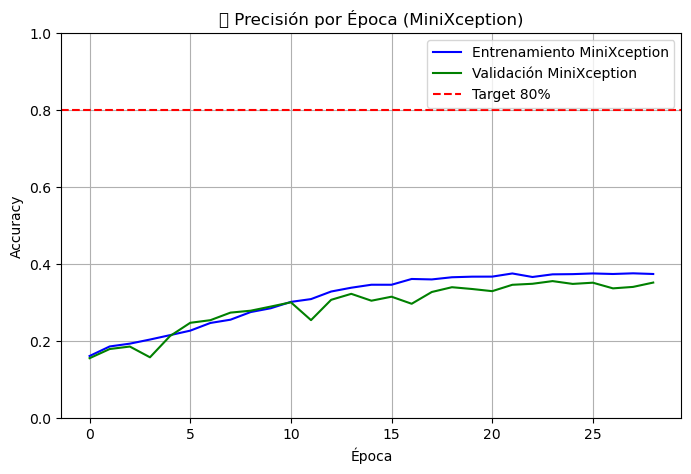

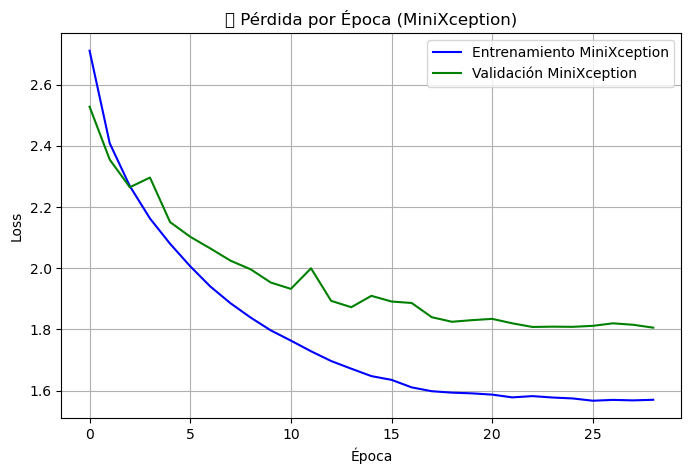


🎭 MATRIZ DE CONFUSIÓN (ENSEMBLE)...


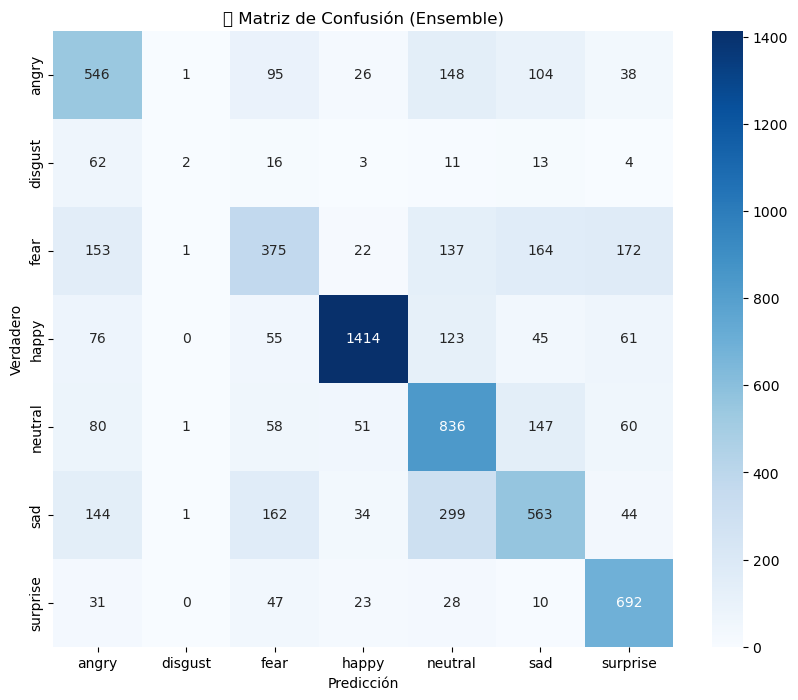


📋 REPORTE DETALLADO (ENSEMBLE)...
              precision    recall  f1-score   support

       angry     0.5000    0.5699    0.5327       958
     disgust     0.3333    0.0180    0.0342       111
        fear     0.4641    0.3662    0.4094      1024
       happy     0.8989    0.7971    0.8449      1774
     neutral     0.5284    0.6780    0.5940      1233
         sad     0.5382    0.4515    0.4911      1247
    surprise     0.6461    0.8327    0.7277       831

    accuracy                         0.6169      7178
   macro avg     0.5585    0.5305    0.5191      7178
weighted avg     0.6193    0.6169    0.6104      7178


📊 Weighted F1-Score: 0.6104

📊 GRÁFICA DE F1-SCORE POR CLASE (ENSEMBLE)...


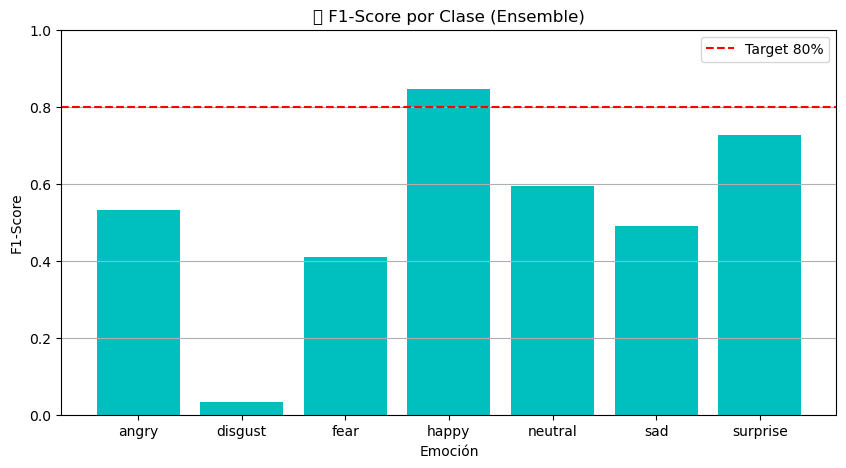


🎯 ANÁLISIS POR CLASE (ENSEMBLE)...

angry:
  Verdaderos positivos: 546
  Falsos positivos: 546
  Falsos negativos: 412
  Se confunde con:
    - disgust: 1 veces
    - fear: 95 veces
    - happy: 26 veces
    - neutral: 148 veces
    - sad: 104 veces
    - surprise: 38 veces

disgust:
  Verdaderos positivos: 2
  Falsos positivos: 4
  Falsos negativos: 109
  Se confunde con:
    - angry: 62 veces
    - fear: 16 veces
    - happy: 3 veces
    - neutral: 11 veces
    - sad: 13 veces
    - surprise: 4 veces

fear:
  Verdaderos positivos: 375
  Falsos positivos: 433
  Falsos negativos: 649
  Se confunde con:
    - angry: 153 veces
    - disgust: 1 veces
    - happy: 22 veces
    - neutral: 137 veces
    - sad: 164 veces
    - surprise: 172 veces

happy:
  Verdaderos positivos: 1414
  Falsos positivos: 159
  Falsos negativos: 360
  Se confunde con:
    - angry: 76 veces
    - fear: 55 veces
    - neutral: 123 veces
    - sad: 45 veces
    - surprise: 61 veces

neutral:
  Verdaderos positivos

In [9]:
# =============================================================================
# 8. 📈 Gráficas de Entrenamiento
# =============================================================================
print("\n📈 GRÁFICAS DE ENTRENAMIENTO...")
if 'history_minixception' in locals():
    # Gráfica de Precisión (MiniXception)
    plt.figure(figsize=(8, 5))
    plt.plot(history_minixception.history['accuracy'], label='Entrenamiento MiniXception', color='b')
    plt.plot(history_minixception.history['val_accuracy'], label='Validación MiniXception', color='g')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target 80%')
    plt.title('🎯 Precisión por Época (MiniXception)')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.savefig('minixception_accuracy_plot.png', dpi=300)
    plt.show()

    # Gráfica de Pérdida (MiniXception)
    plt.figure(figsize=(8, 5))
    plt.plot(history_minixception.history['loss'], label='Entrenamiento MiniXception', color='b')
    plt.plot(history_minixception.history['val_loss'], label='Validación MiniXception', color='g')
    plt.title('📉 Pérdida por Época (MiniXception)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('minixception_loss_plot.png', dpi=300)
    plt.show()
else:
    print("⚠️ Gráficas de entrenamiento no generadas: history_minixception no disponible.")

# Nota: Las gráficas de la CNN no se generan porque history_cnn no está disponible (modelo cargado desde emotion_cnn.h5)

# =============================================================================
# 9. 🎭 Matriz de Confusión (Ensemble)
# =============================================================================
print("\n🎭 MATRIZ DE CONFUSIÓN (ENSEMBLE)...")
try:
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('🎭 Matriz de Confusión (Ensemble)')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.savefig('ensemble_confusion_matrix.png', dpi=300)
    plt.show()
except Exception as e:
    print(f"❌ Error en matriz de confusión: {e}")

# =============================================================================
# 10. 📋 Reporte Detallado (Ensemble)
# =============================================================================
print("\n📋 REPORTE DETALLADO (ENSEMBLE)...")
try:
    report = classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4, output_dict=True)
    print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    print(f"\n📊 Weighted F1-Score: {f1:.4f}")
except Exception as e:
    print(f"❌ Error en reporte: {e}")

# Gráfica de F1-Score por Clase
print("\n📊 GRÁFICA DE F1-SCORE POR CLASE (ENSEMBLE)...")
try:
    f1_scores = [report[emotion]['f1-score'] for emotion in class_labels]
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, f1_scores, color='c')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target 80%')
    plt.title('🎯 F1-Score por Clase (Ensemble)')
    plt.xlabel('Emoción')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.legend()
    plt.savefig('ensemble_f1_score_plot.png', dpi=300)
    plt.show()
except Exception as e:
    print(f"❌ Error en gráfica de F1-score: {e}")

# Análisis de la Matriz de Confusión
print("\n🎯 ANÁLISIS POR CLASE (ENSEMBLE)...")
try:
    for i, emotion in enumerate(class_labels):
        true_positives = cm[i, i]
        false_positives = sum(cm[:, i]) - true_positives
        false_negatives = sum(cm[i, :]) - true_positives
        print(f"\n{emotion}:")
        print(f"  Verdaderos positivos: {true_positives}")
        print(f"  Falsos positivos: {false_positives}")
        print(f"  Falsos negativos: {false_negatives}")
        confusions = [(label, cm[i, j]) for j, label in enumerate(class_labels) if j != i and cm[i, j] > 0]
        if confusions:
            print("  Se confunde con:")
            for conf_emotion, count in confusions:
                print(f"    - {conf_emotion}: {count} veces")
except Exception as e:
    print(f"❌ Error en análisis de confusión: {e}")

# =============================================================================
# 11. 💾 Resumen Final
# =============================================================================
print("\n" + "="*80)
print("📊 RESUMEN FINAL:")
print(f"CNN Test Accuracy: {test_accuracy_cnn:.4f}")
print(f"MiniXception Test Accuracy: {test_accuracy_minixception:.4f}")
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print(f"🎯 Target 80%: {'✅ ALCANZADO' if ensemble_accuracy >= 0.8 else '❌ NO ALCANZADO'}")
print("🔧 Próximos pasos para mejorar:")
print("   • Aumentar sobremuestreo a ~2500 imágenes para disgust, fear, sad")
print("   • Ajustar pesos del ensemble (por ejemplo, 0.7 CNN, 0.3 MiniXception)")
print("   • Reentrenar MiniXception con pesos preentrenados de FER2013 si están disponibles")
print("   • Aumentar épocas a 50 o ajustar learning_rate a 0.00005")
print("="*80)